# Move up the original set

The following editing is done before converting to **WGS**

 1. All region move up 6 units
 2. *Kowloon* and *New Territories* move up 6 units

The input file `combine_hex.geojson` is the original generated map file in *hk80_perry* format. The grid file `map_grid.geojson` is the base grid in *hk80_perry* format.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

from shapely.geometry import Polygon, Point
from pyproj import Proj, transform
import matplotlib.pyplot as plt

In [2]:
from hexMapEditor import hexMapEditor

In [3]:
original_file = hexMapEditor('combine_hex.geojson', 'map_grid.geojson', 0.8)

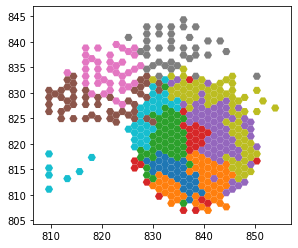

In [4]:
original_file.plot_hex()

In [5]:
result = original_file.get_geoPandas()
result_sorted = result.sort_values(['yid', 'xid'], ascending=[False, False]).copy()
result_sorted.head()

,id,x,y,group,xid,yid,geometry,CACODE,ENAME,CNAME,seat,district
326,326,836.0,844.340501,knnt,30,64,"POLYGON ((836.8 844.3405006737632, 836.4 845.0...",N17,,,1,N
327,327,838.4,842.954860,knnt,32,62,"POLYGON ((839.2 842.9548600277082, 838.8 843.6...",N18,,,1,N
310,310,836.0,842.954860,knnt,30,62,"POLYGON ((836.8 842.9548600277082, 836.4 843.6...",N01,,,1,N
323,323,833.6,842.954860,knnt,28,62,"POLYGON ((834.4 842.9548600277082, 834 843.647...",N14,,,1,N
324,324,831.2,842.954860,knnt,26,62,"POLYGON ((832 842.9548600277082, 831.6 843.647...",N15,,,1,N


In [6]:
# Shift 6 units to top
for _, items in result_sorted.iterrows():
    temp_result = original_file.swap_position(items.xid, items.yid, items.xid, (items.yid + 6), coord='custom')
    if not temp_result:
        print (items)

In [7]:
result_sorted['yid'] = result_sorted['yid'] + 6

In [8]:
# Select the cases in Kowloon and New Territories
result_sorted['district'] = result_sorted.CACODE.str.replace('([A-Z]).*', '\\1')
result_sorted['selected'] = np.where(result_sorted.district.isin(['E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S']), 1, 0)

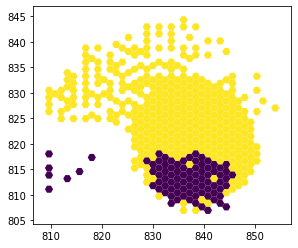

In [9]:
result_sorted.plot(column='selected')
plt.show()

In [10]:
# Shift 6 units to top
for _, items in result_sorted[result_sorted.selected == 1].iterrows():
    temp_result = original_file.swap_position(items.xid, items.yid, items.xid, (items.yid + 6), coord='custom')
    if not temp_result:
        print (items)

In [11]:
current = original_file.get_geoPandas()
current['selected'] = np.where(current.CACODE.isin(['E01', 'A01']), 1, 0)
current[current.selected == 1]

,id,x,y,group,xid,yid,geometry,CACODE,ENAME,CNAME,seat,district,selected
6,6,833.6,820.784610,hki,28,30,"POLYGON ((834.4 820.7846096908265, 834 821.477...",A01,,,1,A,1
87,87,834.8,825.634352,knnt,29,37,"POLYGON ((835.5999999999999 825.6343519520194,...",E01,,,1,E,1


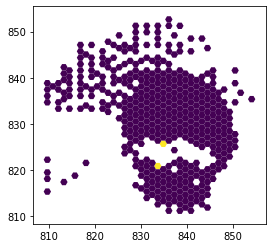

In [12]:
current.plot(column='selected')
plt.show()

In [13]:
# Convert into wgs
wgs_current = current.copy()
hk80_grid = Proj(init=('EPSG:2326 +proj=tmerc +lat_0=22.31213333333334 '
                                   '+lon_0=114.1785555555556 +k=1 +x_0=836694.05 '
                                   '+y_0=819069.8 +ellps=intl +towgs84=-162.619,'
                                   '-276.959,-161.764,0.067753,-2.24365,-1.15883,'
                                   '-1.09425 +units=m +no_defs'))
wgs_grid = Proj(init='epsg:4326')

new_x = []
new_y = []
for tx, ty in zip(wgs_current.x.values, wgs_current.y.values):
    nx, ny = transform(hk80_grid, wgs_grid,tx * 1000,ty * 1000)
    new_x.append(nx)
    new_y.append(ny)

In [14]:
wgs_current['x'] = new_x
wgs_current['y'] = new_y

In [15]:
wgs_current['geometry'] = \
    wgs_current['geometry'].apply(lambda items: Polygon([transform(hk80_grid, wgs_grid,x * 1000,y * 1000) for x, y in items.exterior.coords]))

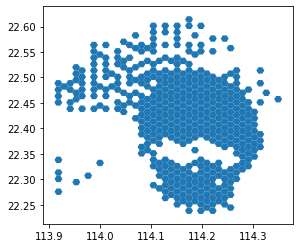

In [16]:
wgs_current.plot()
plt.show()

In [17]:
wgs_current.to_file('combine_hex_wgs.geojson', driver='GeoJSON')